## Additions inspired by Figure 2 
* Pattern correlation between dFull/dPhys and dFull/dRad in latitudinal bands 
* Gradient of change in low flow in boreal forest regions

In [1]:
import scipy as scipy
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FormatStrFormatter
import multiprocessing
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os.path
import xarray as xr 
import pickle 
import pandas as pd

from pandas import DataFrame as df
from scipy.stats import genextreme as gev
from scipy.stats import gumbel_r as gumbel
from netCDF4 import Dataset
from joblib import Parallel, delayed


In [2]:
#Get dimensions from a single file (same will be used for all files)
file1 = 'outflw1161.nc'
dat   = Dataset(file1)
lat   = dat.variables['lat'][:] 
lon   = dat.variables['lon'][:] 
days  = dat.variables['time'][:]

#Read in mask of which gridcells are land vs. ocean
matData   = sio.loadmat('validGridMask_CaMa.mat')
maskVal = matData['maskVal']
#Read in CaMa gridcell areas
matData = sio.loadmat('CaMa_gridAreas.mat')
area    = matData['area']


In [3]:
# Read in extreme flows 
[minCtrl_ann, minFull_ann, minPhys_ann, minRad_ann,maxCtrl_ann,maxFull_ann,
 maxPhys_ann,maxRad_ann,ctrl95_ann,full95_ann,phys95_ann,rad95_ann,ctrl5_ann,
 full5_ann,phys5_ann,rad5_ann] = pickle.load(open('StreamflowAnnualExtremes.pkl', 'rb' ))



## Get useful information from the data 
* Take 30-year average of high/low flows in all cases
* Eliminate places without actual rivers 
* Take difference and %-difference from control

In [4]:
# -- Take average over 30 years -- #
ctrl95_annAvg = np.nanmean(ctrl95_ann,axis=0)   #High flows 
full95_annAvg = np.nanmean(full95_ann,axis=0)
phys95_annAvg = np.nanmean(phys95_ann,axis=0)
rad95_annAvg  = np.nanmean(rad95_ann,axis=0)

ctrl5_annAvg  = np.nanmean(ctrl5_ann,axis=0)    #Low flows 
full5_annAvg  = np.nanmean(full5_ann,axis=0)
phys5_annAvg  = np.nanmean(phys5_ann,axis=0)
rad5_annAvg   = np.nanmean(rad5_ann,axis=0)


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__'

In [5]:
# -- Eliminate places without rivers -- # 
cutoffMax = 500
cutoffMin = 50

#CTRL
maxCtrlNew = ctrl95_annAvg
minCtrlNew = ctrl5_annAvg
maxCtrlNew[np.where(ctrl95_annAvg<=cutoffMax)] = np.nan
minCtrlNew[np.where(ctrl5_annAvg<=cutoffMin)] = np.nan

#FULL 
maxFullNew = full95_annAvg
minFullNew = full5_annAvg
maxFullNew[np.where(ctrl95_annAvg<=cutoffMax)] = np.nan
minFullNew[np.where(ctrl5_annAvg<=cutoffMin)] = np.nan

#PHYS 
maxPhysNew = phys95_annAvg
minPhysNew = phys5_annAvg
maxPhysNew[np.where(ctrl95_annAvg<=cutoffMax)] = np.nan
minPhysNew[np.where(ctrl5_annAvg<=cutoffMin)] = np.nan

#RAD 
maxRadNew = rad95_annAvg
minRadNew = rad5_annAvg
maxRadNew[np.where(ctrl95_annAvg<=cutoffMax)] = np.nan
minRadNew[np.where(ctrl5_annAvg<=cutoffMin)] = np.nan


# -- Define percent change in average min and max flows -- #
pctMinFull = ((minFullNew-minCtrlNew)/minCtrlNew)*100
pctMinPhys = ((minPhysNew-minCtrlNew)/minCtrlNew)*100
pctMinRad  = ((minRadNew-minCtrlNew)/minCtrlNew)*100

pctMaxFull = ((maxFullNew-maxCtrlNew)/maxCtrlNew)*100
pctMaxPhys = ((maxPhysNew-maxCtrlNew)/maxCtrlNew)*100
pctMaxRad  = ((maxRadNew-maxCtrlNew)/maxCtrlNew)*100


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWa

## Carry out pattern correlation for latitudinal bands 
* Choose band width (start with 5 degrees) 
* Look at pattern corr between dFULL/dRAD and dFULL/dPHYS

In [83]:
# print(np.shape(pctMinFull))
# print(np.max(lat))


# # --- Test ---- #


# latSelection = np.where((lat>=30) & (lat<(35)))

# print(lat[latSelection])
# print(np.shape(pctMinFull[latSelection[0][:],:]))

# fullSel     = np.reshape(pctMinFull[latSelection,:],(len(latSelection[0][:])*len(lon)))
# physMinBand = np.reshape(pctMinPhys[latSelection[0][:],:],(len(latSelection[0][:])*len(lon)))

# print('Nanmean Full: ',np.nanmean(fullSel))
# print('Nanmean Phys: ', np.nanmean(physMinBand))

# #Convert to Pandas Dataframe (df.dorr can ignore NaNs, but numpy cannot)
# newfull = df({'Full': fullSel,'Phys':physMinBand})
# print(np.shape(newFull))
# newfull['Full'].corr(newfull['Phys'],method='pearson')



In [6]:
# -- Pattern correlation for very broad bands of latitude (tropics vs. not)

latTrop = np.where((lat>=-30) & (lat<=30))
latNot  = np.where((lat<-30) | (lat>30))

#Define temporary variables that isolate just this latitude band and reshape to 1-D
fullMinTrop = np.reshape(pctMinFull[latTrop[0][:],:],(len(latTrop[0][:])*len(lon)))
physMinTrop = np.reshape(pctMinPhys[latTrop[0][:],:],(len(latTrop[0][:])*len(lon)))
radMinTrop  = np.reshape(pctMinRad[latTrop[0][:],:], (len(latTrop[0][:])*len(lon)))

fullMinNot = np.reshape(pctMinFull[latNot[0][:],:],(len(latNot[0][:])*len(lon)))
physMinNot = np.reshape(pctMinPhys[latNot[0][:],:],(len(latNot[0][:])*len(lon)))
radMinNot  = np.reshape(pctMinRad[latNot[0][:],:], (len(latNot[0][:])*len(lon)))

#Use Pandas to convert to a dataframe and get corrcoef (can handle NaNs, whereas numpy cannot)
tropMinPhys = df({'Full': fullMinTrop,'Phys':physMinTrop})
tropMinRad  = df({'Full': fullMinTrop,'Rad':radMinTrop})
notMinPhys = df({'Full': fullMinNot,'Phys': physMinNot})
notMinRad  = df({'Full': fullMinNot,'Rad': radMinNot})

tropCorrMinPhys = tropMinPhys['Full'].corr(tropMinPhys['Phys'],method='pearson')
tropCorrMinRad  = tropMinRad['Full'].corr(tropMinRad['Rad'],method='pearson')
notCorrMinPhys = notMinPhys['Full'].corr(notMinPhys['Phys'],method='pearson')
notCorrMinRad  = notMinRad['Full'].corr(notMinRad['Rad'],method='pearson')

print('Correlation for Tropics: PHYS ', tropCorrMinPhys)
print('Correlation for Tropics: RAD  ', tropCorrMinRad)
print()
print('Correlation for not-Tropics: PHYS ', notCorrMinPhys)
print('Correlation for not-Tropics: RAD  ', notCorrMinRad)




Correlation for Tropics: PHYS  0.6668547330708157
Correlation for Tropics: RAD   0.3633192153952114

Correlation for not-Tropics: PHYS  0.4809769659232952
Correlation for not-Tropics: RAD   0.8120083054130222


## New pass at taking rolling mean and making these plots 

* "Do the smoothing in latitude and then that will propagate into your zonal spread metric." 

In [6]:
# --- High Flow ---- # 

# Smooth in latitude (& longitude?) -- 5 degrees = 20 samples 
fullSmooth = df(pctMaxFull).rolling(20,min_periods=1,axis=0).apply(np.nanmean)
physSmooth = df(pctMaxPhys).rolling(20,min_periods=1,axis=0).apply(np.nanmean)
radSmooth = df(pctMaxRad).rolling(20,min_periods=1,axis=0).apply(np.nanmean)

lonFullSmooth = fullSmooth.rolling(20,min_periods=1,axis=1).apply(np.nanmean)
lonPhysSmooth = physSmooth.rolling(20,min_periods=1,axis=1).apply(np.nanmean)
lonRadSmooth = radSmooth.rolling(20,min_periods=1,axis=1).apply(np.nanmean)

# Average over longitude and take std dev
avgFull = np.nanmean(lonFullSmooth,axis=1)
avgPhys = np.nanmean(lonPhysSmooth,axis=1)
avgRad  = np.nanmean(lonRadSmooth, axis=1)

stdFull = np.nanstd(lonFullSmooth,axis=1)
stdPhys = np.nanstd(lonPhysSmooth,axis=1)
stdRad  = np.nanstd(lonRadSmooth,axis=1)

full25  = np.nanpercentile(lonFullSmooth,25,axis=1)
full75  = np.nanpercentile(lonFullSmooth,75,axis=1)
phys25  = np.nanpercentile(lonPhysSmooth,25,axis=1)
phys75  = np.nanpercentile(lonPhysSmooth,75,axis=1)
rad25   = np.nanpercentile(lonRadSmooth,25,axis=1)
rad75   = np.nanpercentile(lonRadSmooth,75,axis=1)

# ---- Low Flow ---- # 
fullMinSmooth = df(pctMinFull).rolling(20,min_periods=1,axis=0).apply(np.nanmean)
physMinSmooth = df(pctMinPhys).rolling(20,min_periods=1,axis=0).apply(np.nanmean)
radMinSmooth  = df(pctMinRad).rolling(20,min_periods=1,axis=0).apply(np.nanmean)

lonFullMinSmooth = fullMinSmooth.rolling(20,min_periods=1,axis=1).apply(np.nanmean)
lonPhysMinSmooth = physMinSmooth.rolling(20,min_periods=1,axis=1).apply(np.nanmean)
lonRadMinSmooth  = radMinSmooth.rolling(20,min_periods=1,axis=1).apply(np.nanmean)

# Average over longitude and take std dev
avgMinFull = np.nanmean(lonFullMinSmooth,axis=1)
avgMinPhys = np.nanmean(lonPhysMinSmooth,axis=1)
avgMinRad  = np.nanmean(radMinSmooth, axis=1)

stdMinFull = np.nanstd(lonFullMinSmooth,axis=1)
stdMinPhys = np.nanstd(lonPhysMinSmooth,axis=1)
stdMinRad  = np.nanstd(lonRadMinSmooth,axis=1)

fullMin25  = np.nanpercentile(lonFullMinSmooth,25,axis=1)
fullMin75  = np.nanpercentile(lonFullMinSmooth,75,axis=1)
physMin25  = np.nanpercentile(lonPhysMinSmooth,25,axis=1)
physMin75  = np.nanpercentile(lonPhysMinSmooth,75,axis=1)
radMin25   = np.nanpercentile(lonRadMinSmooth,25,axis=1)
radMin75   = np.nanpercentile(lonRadMinSmooth,75,axis=1)


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/Users/meganfowle

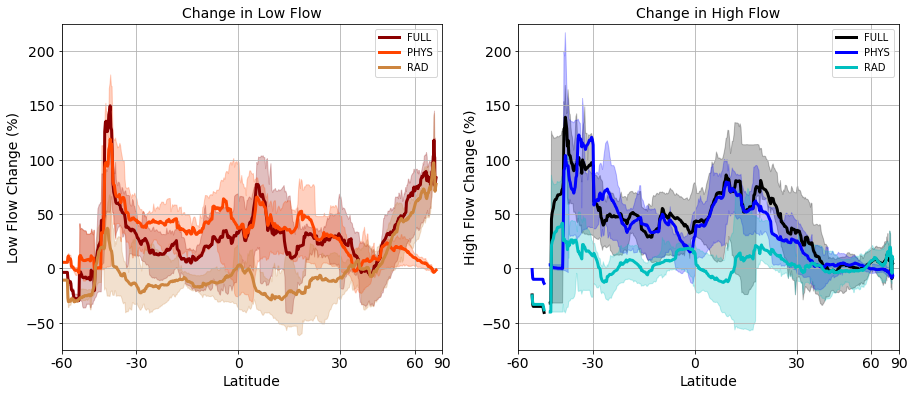

In [23]:
# Plot 
fig, ax_array = plt.subplots(1,2)
ax1,ax2 = ax_array.flatten()
fig.set_size_inches(15,6)
my_fontsize = 12

#Plot Low Flow against sin of latitude (in radians)
ax1.plot(np.sin(lat*((2*np.pi)/360)),avgMinFull,color='darkred',label='FULL',linewidth=3)
ax1.plot(np.sin(lat*((2*np.pi)/360)),avgMinPhys,color ='orangered',label='PHYS',linewidth=3)
ax1.plot(np.sin(lat*((2*np.pi)/360)),avgMinRad, color='peru',label='RAD',linewidth=3)
# #Add error "bars"
ax1.fill_between(np.sin(lat*((2*np.pi)/360)),fullMin25,fullMin75,alpha=0.25,color='darkred')
ax1.fill_between(np.sin(lat*((2*np.pi)/360)),physMin25,physMin75,alpha=0.25,color='orangered')
ax1.fill_between(np.sin(lat*((2*np.pi)/360)),radMin25,radMin75,alpha=0.25,color='peru')
#Add plot options
ax1.legend(fontsize=10)
ax1.set_title('Change in Low Flow',fontsize=14)
ax1.set_xlabel('Latitude',fontsize=14)
ax1.set_ylabel('Low Flow Change (%)',fontsize=14)
ax1.set_ylim([-75,225])
ax1.set_xlim([-60,90])
ax1.grid()
#Change x-labels
locs = np.array([-.86603,-0.5,0,0.5,0.86603,1])
labels = [np.arcsin(locs)*(360/(2*np.pi))]
ax1.set_xticks(ticks=locs) 
#ax1.set_xticklabels(labels[0][:])
ax1.set_xticklabels([-60,-30,0,30,60,90],fontsize=14)
ax1.tick_params(axis='y',labelsize=14)
# Beat them into submission and set them back again
#ax1.set_xticklabels([str(round(float(label), 2)) for label in labels[0][:]],{'fontsize':11})
ax1.set_xlim([-0.86603,1])

#Plot High Flow 
ax2.plot(np.sin(lat*((2*np.pi)/360)),avgFull,color='black',label='FULL',linewidth=3)
ax2.plot(np.sin(lat*((2*np.pi)/360)),avgPhys,color ='b',label='PHYS',linewidth=3)
ax2.plot(np.sin(lat*((2*np.pi)/360)),avgRad, color='c',label='RAD',linewidth=3)
#Add error "bars"
ax2.fill_between(np.sin(lat*((2*np.pi)/360)),(full25),(full75),alpha=0.25,color='black')
ax2.fill_between(np.sin(lat*((2*np.pi)/360)),(phys25),(phys75),alpha=0.25,color='b')
ax2.fill_between(np.sin(lat*((2*np.pi)/360)),(rad25),(rad75),alpha=0.25,color='c')
#Add plot options
ax2.legend(fontsize=10)
ax2.set_title('Change in High Flow',fontsize=14)
ax2.set_xlabel('Latitude',fontsize=14)
ax2.set_ylabel('High Flow Change (%)',fontsize=14)
ax2.set_ylim([-75,225])
ax2.set_xlim([-60,90])
ax2.grid()
#Change x-labels
locs = np.array([-.86603,-0.5,0,0.5,0.86603,1])
labels = [np.arcsin(locs)*(360/(2*np.pi))]
ax2.set_xticks(ticks=locs) 
ax2.set_xticklabels([-60,-30,0,30,60,90],fontsize=14)
ax2.tick_params(axis='y',labelsize=14)
# Beat them into submission and set them back again
#ax2.set_xticklabels([str(round(float(label), 2)) for label in labels[0][:]],{'fontsize':11})
ax2.set_xlim([-0.86603,1])

fig.savefig('LatitudinalStreamflow_5degSmooth_newColors.pdf',bbox_inches = 'tight')  #Save figure as pdf


## Use same method above to make similar latitudinal plots of soil moisture and precip
**NOTE: This section will not work unless raw files requested. Contact for access.** 

In [8]:
# # --- Get CESM vars --- #

# fileBase = '/Users/meganfowler/gp_fuse/Flooding-physiology/RelatedCESMvariables/'

# # Read in soil liquid
# fCtrl = xr.open_dataset((fileBase + 'cesm1_0_6.1850_prei.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# fFull = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# fPhys = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# fRad  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlyConcat_Meg.nc'),decode_times=False)
# ctrlSoilLiq = fCtrl.SOILLIQ
# fullSoilLiq = fFull.SOILLIQ
# physSoilLiq = fPhys.SOILLIQ
# radSoilLiq  = fRad.SOILLIQ

# # Read in soil ice 
# fCtrl_ice = xr.open_dataset((fileBase + 'cesm1_0_6.1850_prei.1deg.001.clm2.MonthlySoilIce.nc'),decode_times=False)
# fFull_ice = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fulgb.1deg.002.clm2.MonthlySoilIce.nc'),decode_times=False)
# fPhys_ice = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fixgb.1deg.001.clm2.MonthlySoilIce.nc'),decode_times=False)
# fRad_ice  = xr.open_dataset((fileBase + 'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.clm2.MonthlySoilIce.nc'),decode_times=False)
# ctrlSoilIce = fCtrl_ice.SOILICE
# fullSoilIce = fFull_ice.SOILICE
# physSoilIce = fPhys_ice.SOILICE
# radSoilIce  = fRad_ice.SOILICE

# #Define total soil moisture 
# ctrlSoil = ctrlSoilLiq + ctrlSoilIce
# fullSoil = fullSoilLiq + fullSoilIce
# physSoil = physSoilLiq + physSoilIce
# radSoil  = radSoilLiq  + radSoilIce

# #Define 1m soil moisture 
# ctrlSoil_1m = np.nansum(ctrlSoil[:,0:7,:,:],axis=1)  #[kg/m2]
# fullSoil_1m = np.nansum(fullSoil[:,0:7,:,:],axis=1)
# physSoil_1m = np.nansum(physSoil[:,0:7,:,:],axis=1)
# radSoil_1m  = np.nansum(radSoil[:,0:7,:,:],axis=1)

# #Read in total precipitation (liq+ice)
# fCtrl_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_prei.1deg.001.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False) 
# fFull_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fulgb.1deg.002.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
# fPhys_prect = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fixgb.1deg.001.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)
# fRad_prect  = xr.open_dataset((fileBase+'cesm1_0_6.1850_4xco2_fdbgb.1deg.002.cam2.h0.MonthlyRainAndSnow.nc'),decode_times=False)

# ctrlPrect = fCtrl_prect.PRECT     #[m/s]
# fullPrect = fFull_prect.PRECT
# physPrect = fPhys_prect.PRECT
# radPrect  = fRad_prect.PRECT

# ctrlPrecsc = fCtrl_prect.PRECSC
# fullPrecsc = fFull_prect.PRECSC
# physPrecsc = fPhys_prect.PRECSC
# radPrecsc  = fRad_prect.PRECSC

# ctrlPrecsl = fCtrl_prect.PRECSL
# fullPrecsl = fFull_prect.PRECSL
# physPrecsl = fPhys_prect.PRECSL
# radPrecsl  = fRad_prect.PRECSL

# ctrlPrecip = ctrlPrect+ctrlPrecsc+ctrlPrecsl
# fullPrecip = fullPrect+fullPrecsc+fullPrecsl 
# physPrecip = physPrect+physPrecsc+physPrecsl
# radPrecip  = radPrect+radPrecsc+radPrecsl

# #CESM lat and lon
# cesmLon = fCtrl.lon.values
# cesmLat = fCtrl.lat.values


In [9]:
print(np.shape(ctrlSoil_1m))
print(np.shape(cesmLon))

print(cesmLon[100])
print(cesmLon[104])

(360, 192, 288)
(288,)
125.0
130.0


**Soil moisture**

In [10]:
# --- Average over time --- #
avgSoilCtrl = np.nanmean(ctrlSoil_1m,axis=0)
avgSoilFull = np.nanmean(fullSoil_1m,axis=0)
avgSoilPhys = np.nanmean(physSoil_1m,axis=0)
avgSoilRad  = np.nanmean(radSoil_1m,axis=0)

# -- Define percent change in average  -- #
pctSoilFull = ((avgSoilFull-avgSoilCtrl)/avgSoilCtrl)*100
pctSoilPhys = ((avgSoilPhys-avgSoilCtrl)/avgSoilCtrl)*100
pctSoilRad  = ((avgSoilRad-avgSoilCtrl)/avgSoilCtrl)*100


/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# --- Apply smoothing --- #

# Smooth in latitude - roughly 5 samples for 5 degrees 
fullSoilSmooth = df(pctSoilFull).rolling(5,min_periods=1,axis=0).apply(np.nanmean)
physSoilSmooth = df(pctSoilPhys).rolling(5,min_periods=1,axis=0).apply(np.nanmean)
radSoilSmooth  = df(pctSoilRad).rolling(5,min_periods=1,axis=0).apply(np.nanmean)

#Smooth in longitude -  4 samples for 5 degrees 
lonSoilFullSmooth = fullSoilSmooth.rolling(4,min_periods=1,axis=1).apply(np.nanmean)
lonSoilPhysSmooth = physSoilSmooth.rolling(4,min_periods=1,axis=1).apply(np.nanmean)
lonSoilRadSmooth  = radSoilSmooth.rolling(4,min_periods=1,axis=1).apply(np.nanmean)

# Average over longitude and take std dev
avgSoilFull = np.nanmean(lonSoilFullSmooth,axis=1)
avgSoilPhys = np.nanmean(lonSoilPhysSmooth,axis=1)
avgSoilRad  = np.nanmean(lonSoilRadSmooth, axis=1)

fullSoil25  = np.nanpercentile(lonSoilFullSmooth,25,axis=1)
fullSoil75  = np.nanpercentile(lonSoilFullSmooth,75,axis=1)
physSoil25  = np.nanpercentile(lonSoilPhysSmooth,25,axis=1)
physSoil75  = np.nanpercentile(lonSoilPhysSmooth,75,axis=1)
radSoil25   = np.nanpercentile(lonSoilRadSmooth,25,axis=1)
radSoil75   = np.nanpercentile(lonSoilRadSmooth,75,axis=1)



/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/meganfowler/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


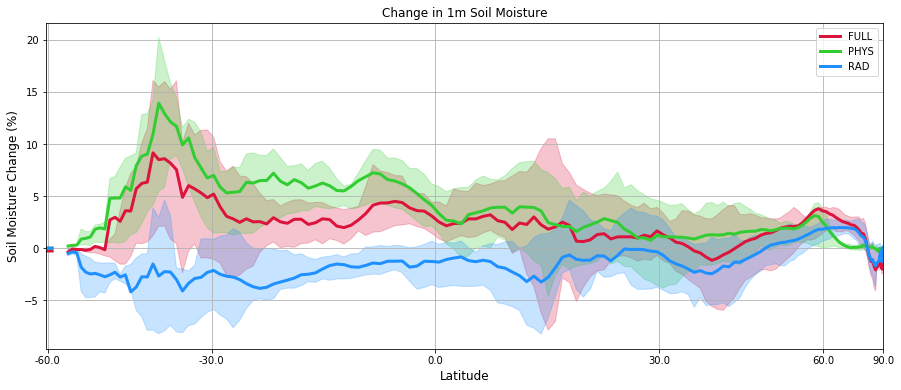

In [12]:
# Plot 
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(15,6)
my_fontsize = 12

#Plot Low Flow against sin of latitude (in radians)
ax1.plot(np.sin(cesmLat*((2*np.pi)/360)),avgSoilFull,color='Crimson',label='FULL',linewidth=3)
ax1.plot(np.sin(cesmLat*((2*np.pi)/360)),avgSoilPhys,color ='LimeGreen',label='PHYS',linewidth=3)
ax1.plot(np.sin(cesmLat*((2*np.pi)/360)),avgSoilRad, color='DodgerBlue',label='RAD',linewidth=3)
# #Add error "bars"
ax1.fill_between(np.sin(cesmLat*((2*np.pi)/360)),fullSoil25,fullSoil75,alpha=0.25,color='Crimson')
ax1.fill_between(np.sin(cesmLat*((2*np.pi)/360)),physSoil25,physSoil75,alpha=0.25,color='LimeGreen')
ax1.fill_between(np.sin(cesmLat*((2*np.pi)/360)),radSoil25,radSoil75,alpha=0.25,color='DodgerBlue')
#Add plot options
ax1.legend(fontsize=10)
ax1.set_title('Change in 1m Soil Moisture',fontsize=my_fontsize)
ax1.set_xlabel('Latitude',fontsize=my_fontsize)
ax1.set_ylabel('Soil Moisture Change (%)',fontsize=my_fontsize)
ax1.grid()
#Change x-labels
locs = np.array([-.86603,-0.5,0,0.5,0.86603,1])
labels = [np.arcsin(locs)*(360/(2*np.pi))]
ax1.set_xticks(ticks=locs) 
ax1.set_xticklabels(labels[0][:])
# Beat them into submission and set them back again
ax1.set_xticklabels([str(round(float(label), 2)) for label in labels[0][:]])
ax1.set_xlim([-.87,1])

fig.savefig('LatitudinalSoilMoisture-1m_5degSmooth.pdf',bbox_inches = 'tight')  #Save figure as pdf




**Precipitation**

In [30]:
np.shape(ctrlPrecip)

(360, 192, 288)

In [13]:
# --- Average over time --- #
avgPrecipCtrl = np.nanmean(ctrlPrecip,axis=0)
avgPrecipFull = np.nanmean(fullPrecip,axis=0)
avgPrecipPhys = np.nanmean(physPrecip,axis=0)
avgPrecipRad  = np.nanmean(radPrecip,axis=0)

# -- Define percent change in average  -- #
pctPrecipFull = ((avgPrecipFull-avgPrecipCtrl)/avgPrecipCtrl)*100
pctPrecipPhys = ((avgPrecipPhys-avgPrecipCtrl)/avgPrecipCtrl)*100
pctPrecipRad  = ((avgPrecipRad-avgPrecipCtrl)/avgPrecipCtrl)*100


In [14]:
# --- Apply smoothing --- #

# Smooth in latitude - roughly 5 samples for 5 degrees 
fullPrecipSmooth = df(pctPrecipFull).rolling(5,min_periods=1,axis=0).apply(np.nanmean)
physPrecipSmooth = df(pctPrecipPhys).rolling(5,min_periods=1,axis=0).apply(np.nanmean)
radPrecipSmooth  = df(pctPrecipRad).rolling(5,min_periods=1,axis=0).apply(np.nanmean)

#Smooth in longitude -  4 samples for 5 degrees 
lonPrecipFullSmooth = fullPrecipSmooth.rolling(4,min_periods=1,axis=1).apply(np.nanmean)
lonPrecipPhysSmooth = physPrecipSmooth.rolling(4,min_periods=1,axis=1).apply(np.nanmean)
lonPrecipRadSmooth  = radPrecipSmooth.rolling(4,min_periods=1,axis=1).apply(np.nanmean)

# Average over longitude and take std dev
avgPrecipFull = np.nanmean(lonPrecipFullSmooth,axis=1)
avgPrecipPhys = np.nanmean(lonPrecipPhysSmooth,axis=1)
avgPrecipRad  = np.nanmean(lonPrecipRadSmooth, axis=1)

fullPrecip25  = np.nanpercentile(lonPrecipFullSmooth,25,axis=1)
fullPrecip75  = np.nanpercentile(lonPrecipFullSmooth,75,axis=1)
physPrecip25  = np.nanpercentile(lonPrecipPhysSmooth,25,axis=1)
physPrecip75  = np.nanpercentile(lonPrecipPhysSmooth,75,axis=1)
radPrecip25   = np.nanpercentile(lonPrecipRadSmooth,25,axis=1)
radPrecip75   = np.nanpercentile(lonPrecipRadSmooth,75,axis=1)


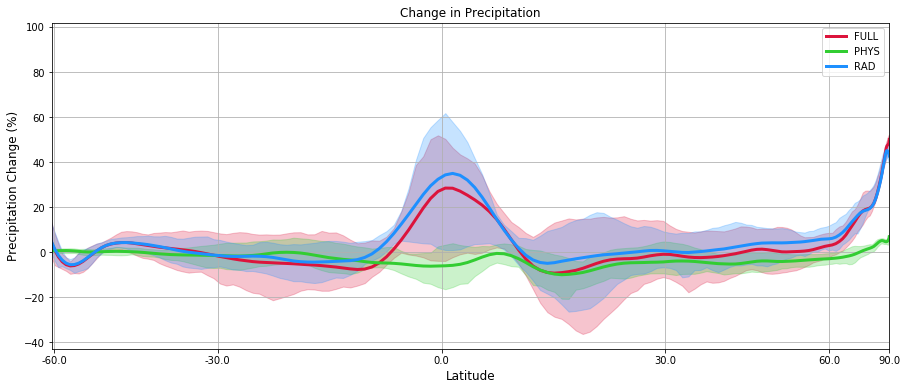

In [15]:
# Plot 
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(15,6)
my_fontsize = 12

#Plot Low Flow against sin of latitude (in radians)
ax1.plot(np.sin(cesmLat*((2*np.pi)/360)),avgPrecipFull,color='Crimson',label='FULL',linewidth=3)
ax1.plot(np.sin(cesmLat*((2*np.pi)/360)),avgPrecipPhys,color ='LimeGreen',label='PHYS',linewidth=3)
ax1.plot(np.sin(cesmLat*((2*np.pi)/360)),avgPrecipRad, color='DodgerBlue',label='RAD',linewidth=3)
# #Add error "bars"
ax1.fill_between(np.sin(cesmLat*((2*np.pi)/360)),fullPrecip25,fullPrecip75,alpha=0.25,color='Crimson')
ax1.fill_between(np.sin(cesmLat*((2*np.pi)/360)),physPrecip25,physPrecip75,alpha=0.25,color='LimeGreen')
ax1.fill_between(np.sin(cesmLat*((2*np.pi)/360)),radPrecip25,radPrecip75,alpha=0.25,color='DodgerBlue')
#Add plot options
ax1.legend(fontsize=10)
ax1.set_title('Change in Precipitation',fontsize=my_fontsize)
ax1.set_xlabel('Latitude',fontsize=my_fontsize)
ax1.set_ylabel('Precipitation Change (%)',fontsize=my_fontsize)
ax1.grid()
#Change x-labels
locs = np.array([-.86603,-0.5,0,0.5,0.86603,1])
labels = [np.arcsin(locs)*(360/(2*np.pi))]
ax1.set_xticks(ticks=locs) 
ax1.set_xticklabels(labels[0][:])
# Beat them into submission and set them back again
ax1.set_xticklabels([str(round(float(label), 2)) for label in labels[0][:]])
ax1.set_xlim([-.87,1])

fig.savefig('LatitudinalPrecipitation_5degSmooth.pdf',bbox_inches = 'tight')  #Save figure as pdf


